# Import

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Validation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

# Classification models
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [2]:
train_df = pd.read_csv("./train_loan.csv")
test_df = pd.read_csv("./test_loan.csv")

In [3]:
train_df.shape

(614, 13)

In [4]:
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


<Figure size 720x360 with 0 Axes>

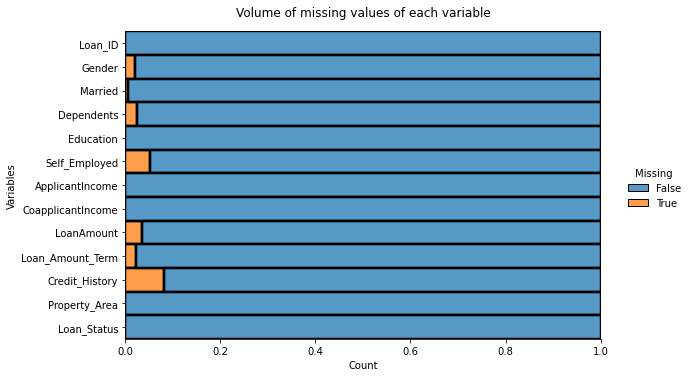

In [6]:
# Visualization of the missing values
plt.figure(figsize=(10,5))
sns.displot(train_df.isna().melt(value_name="Missing", var_name="Variables"), y="Variables", hue="Missing", multiple="fill",  aspect=1.75)

plt.title("Volume of missing values of each variable", pad=15)
plt.show()

# EDA & preprocessing

Observing each variable, checking the distributions of their values, filling the missing ones.

## Visualization

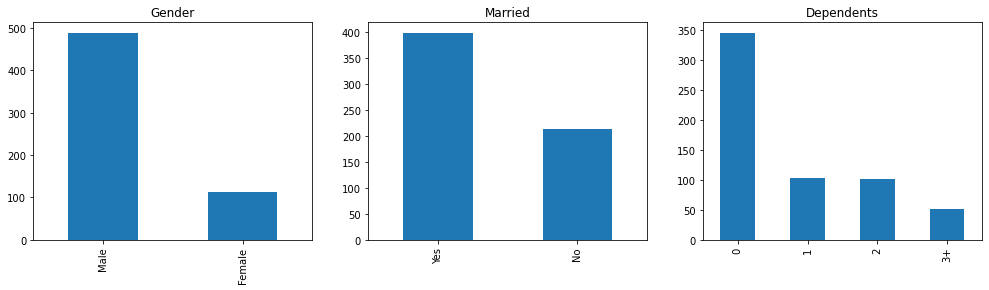

In [7]:
# Checking the distributions of categorical features

fig, ax  = plt.subplots(1,3, figsize=(17,4))

train_df["Gender"].value_counts().plot(kind="bar", ax=ax[0], title="Gender")
train_df["Married"].value_counts().plot(kind="bar", ax=ax[1], title="Married")
train_df["Dependents"].value_counts().plot(kind="bar", ax=ax[2], title="Dependents")

plt.show()

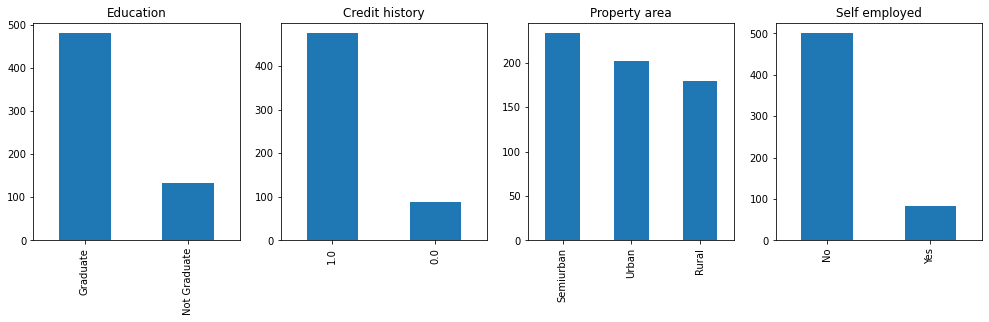

In [8]:
fig, ax = plt.subplots(1,4, figsize=(17,4))

train_df["Education"].value_counts().plot(kind="bar", ax=ax[0], title="Education")
train_df["Credit_History"].value_counts().plot(kind="bar", ax=ax[1], title="Credit history")
train_df["Property_Area"].value_counts().plot(kind="bar", ax=ax[2], title="Property area")
train_df["Self_Employed"].value_counts().plot(kind="bar", ax=ax[3], title="Self employed")
plt.show()

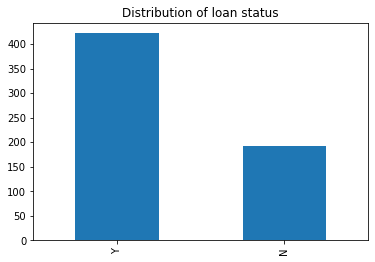

In [9]:
# 69% of the loan requests were accepted
train_df["Loan_Status"].value_counts().plot(kind="bar", title="Distribution of loan status")
plt.show()

In [10]:
train_df["Loan_Status"] = train_df["Loan_Status"].apply(lambda x: 1 if x == "Y" else 0)

## Missing values, encoding

The distributions of each categorical feature are helping us which value would be suitable for filling the missing values. 

After we parsed which categorical value would be better to fill up the missing one, we have to encode each categories to make classification process easier for the models.

There are several ways to encode categorical variables:

### Binary categorical variable

In [11]:
# Simply encoding binary genders as Male=0, Female=1 using lambda function. With this method we also filling the NaN values as a Male. 
train_df["Gender"] = train_df["Gender"].apply(lambda x: 1 if x == "Female" else 0)

In [12]:
# Fill up the missing Married status with "Yes", then encoding binary.
train_df["Married"] = train_df["Married"].fillna("Yes")
train_df["Married"] = train_df["Married"].apply(lambda x: 1 if x == "Yes" else 0)

In [13]:
# Same with other categorical features
train_df["Education"] = train_df["Education"].fillna("Graduate")
train_df["Education"] = train_df["Education"].apply(lambda x: 1 if x == "Graduate" else 0)

train_df["Self_Employed"] = train_df["Self_Employed"].apply(lambda x: 1 if x == "Yes" else 0)

train_df["Credit_History"] = train_df["Credit_History"].fillna(1.0)
train_df["Credit_History"] = train_df["Credit_History"].apply(lambda x: 1 if x == 1.0 else 0)

### Multilevel categorical variable

Map function

In [14]:
# If there are more categories than two, one way to encode them easier is using map function.

# Creating the dictionary for encoding
dep_map = {"0":0, "1":1, "2":2, "3+":3}

# Filling up the missing values
train_df["Dependents"] = train_df["Dependents"].fillna("0")

# And execute map function
train_df["Dependents"] = train_df["Dependents"].map(dep_map)

# Converting float values to integer
train_df["Dependents"] = train_df["Dependents"].astype(int)

LabelEncoder

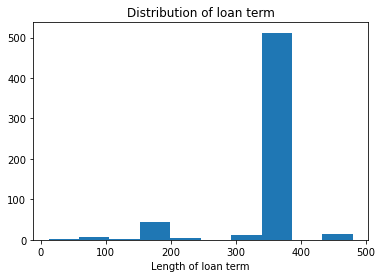

In [15]:
# An easier way to encode multi level categories is LabelEncoder
# In Label Encoding retaining the order of categories is essential
# The lenght of the loan term can also an important information for classification 
# \so lableling with the right order is vital
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

plt.hist(train_df["Loan_Amount_Term"], bins=10)
plt.title("Distribution of loan term")
plt.xlabel("Length of loan term")
plt.show()

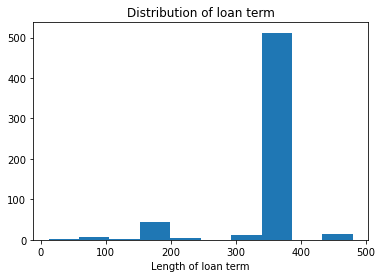

In [16]:
plt.hist(train_df["Loan_Amount_Term"], bins=10)
plt.title("Distribution of loan term")
plt.xlabel("Length of loan term")
plt.show()

In [17]:
train_df["Loan_Amount_Term"] = train_df["Loan_Amount_Term"].fillna(360)
train_df["Loan_Amount_Term"] = train_df["Loan_Amount_Term"].astype(int)

train_df["Loan_Amount_Term"] = le.fit_transform(train_df["Loan_Amount_Term"])

Dummy Encoding

It is similar to one-hot encoding, but it has a small improvement that it can drop one feature(drop_first=True).

In [18]:
# Making a dummy df with a binary encoding technique then concatenate to our basic df
prop_df = pd.get_dummies(train_df["Property_Area"], prefix="area")

In [19]:
# Concatenate horizontaly, not verticaly
train_df = pd.concat([train_df, prop_df], axis=1)

In [20]:
train_df["area_Semiurban"] = train_df["area_Semiurban"].astype(int)
train_df["area_Rural"] =train_df["area_Rural"].astype(int)
train_df["area_Urban"] = train_df["area_Urban"].astype(int)

### Numerical values

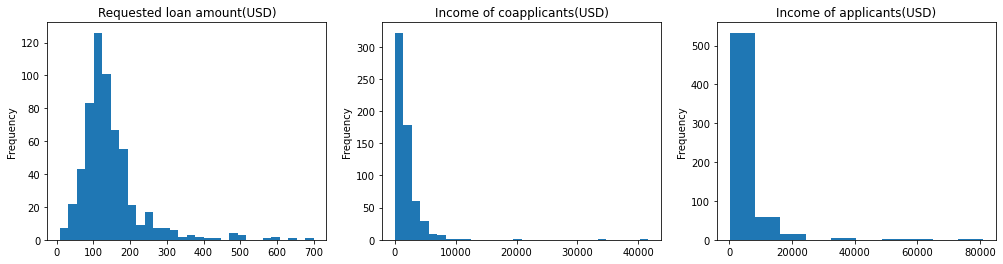

In [21]:
ticks = np.arange(0,80001,20000)
fig, ax = plt.subplots(1,3, figsize=(17,4))

train_df["LoanAmount"].plot(kind="hist", bins=30, 
                            ax=ax[0], title="Requested loan amount(USD)")
train_df["CoapplicantIncome"].plot(kind="hist", bins=30, 
                            ax=ax[1], title="Income of coapplicants(USD)")
train_df["ApplicantIncome"].plot(kind="hist", bins=10, 
                            ax=ax[2], title="Income of applicants(USD)",xticks=ticks)

plt.show()

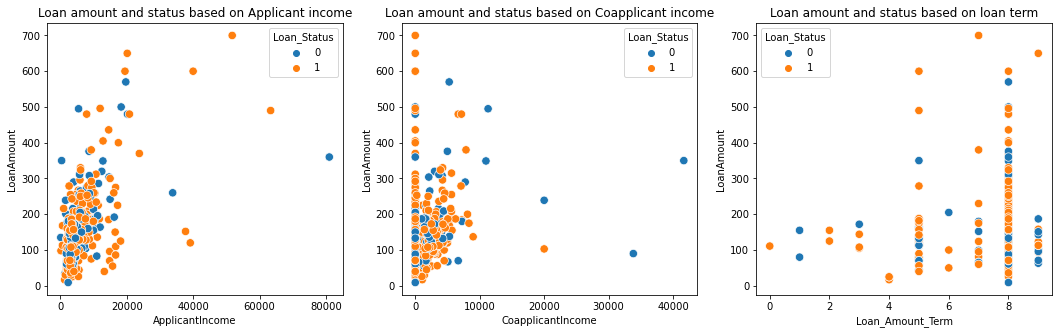

In [22]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

sns.scatterplot(data=train_df, x="ApplicantIncome", y="LoanAmount",
                s=70,hue="Loan_Status", 
                ax=ax[0]).set(title="Loan amount and status based on Applicant income", xticks=ticks)
sns.scatterplot(data=train_df, x="CoapplicantIncome", y="LoanAmount",
                s=70,hue="Loan_Status", 
                ax=ax[1]).set(title="Loan amount and status based on Coapplicant income")
sns.scatterplot(data=train_df, x="Loan_Amount_Term", y="LoanAmount",
                s=70,hue="Loan_Status", ax=ax[2]).set(title="Loan amount and status based on loan term")

plt.show()

It looks like reasonable to fill up the missing loan amount values with the mean of amounts.

In [23]:
# The mean of the loan amount ~146$.
loan_mean = int(round(train_df["LoanAmount"].mean(),0))
train_df["LoanAmount"] = train_df["LoanAmount"].fillna(loan_mean).astype(int)

In [24]:
# Convert the coapplicant column to integer
train_df["CoapplicantIncome"] = train_df["CoapplicantIncome"].astype(int) 

In [25]:
# No missing values anymore
train_df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
area_Rural           0
area_Semiurban       0
area_Urban           0
dtype: int64

In [26]:
# Prepare the dataset we are going to use for heatmap and modeling
# Dropping letterbased features and move the target column to the end
data = train_df.drop(["Loan_ID", "Property_Area"], 1)
status = data.pop("Loan_Status")
data = pd.concat([data, status], 1)

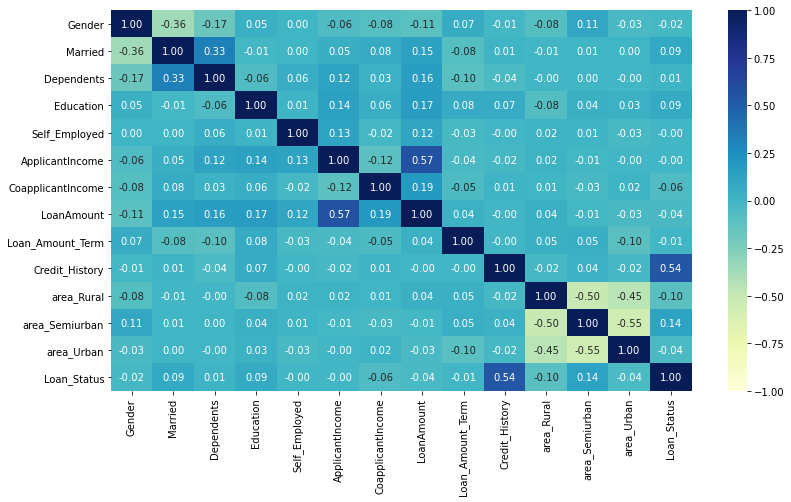

In [27]:
# Checking the correlation between the variables on heatmap
corr = data.corr()

plt.figure(figsize=(13,7))

sns.heatmap(corr, vmin=-1, vmax=1, cmap="YlGnBu", annot=True, fmt=".2f")

plt.show()

# Modeling

Creating functions makes the model trial easier and faster, so small adjustments has to be made manually only ones.

Following models are going to be tested: 
-Logistic Regression, 
-DecisionTree, 
-RandomForest, 
-KNeighborsClassifier 
-and GradientBoostingClassifier

Basically, every model has 2 types of prediction, one that makes the classification by the probability of the classes and the other by the usual way. 
KNeighborsClassifier needs the input values scaled, thereby the functions were transformed with the necessary completions.

## Functions and models

### Functions

In [28]:
# Collect all the metric results in a df to find the best perfomed model

validation = pd.DataFrame({"Model":[], "Accuracy":[], "Recall": [], "Precision":[], "ROC-AUC":[]})

In [29]:
def class_pred(cmodel, model_name, df, test_size=0.2):
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    model = cmodel
    model.fit(X_train, y_train)
    
    cmodel_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, cmodel_pred)
    recall = recall_score(y_test, cmodel_pred)
    precision = precision_score(y_test, cmodel_pred)
    roc = roc_auc_score(y_test, cmodel_pred)
    
    validation.loc[validation.shape[0]+1] = [model_name, acc, recall, precision, roc]

In [30]:
def class_pred_proba(cmodel, model_name, df, test_size=0.2):
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    model = cmodel
    
    cmodel_pred = cross_val_predict(model, X, y, cv=4, method="predict_proba")
    
    cmodel_pred = pd.Series(cmodel_pred[:,1]).apply(lambda x: 1 if x >= 0.6 else 0)
    
    acc = accuracy_score(y, cmodel_pred)
    recall = recall_score(y, cmodel_pred)
    precision = precision_score(y, cmodel_pred)
    roc = roc_auc_score(y, cmodel_pred)
    
    validation.loc[validation.shape[0]+1] = [model_name, acc, recall, precision, roc]

In [31]:
def class_pred_scaled(cmodel, model_name, df, test_size=0.2):
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    X = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    
    model = cmodel
    model.fit(X_train, y_train)
    
    cmodel_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, cmodel_pred)
    recall = recall_score(y_test, cmodel_pred)
    precision = precision_score(y_test, cmodel_pred)
    roc = roc_auc_score(y_test, cmodel_pred)
    
    validation.loc[validation.shape[0]+1] = [model_name, acc, recall, precision, roc]

In [32]:
def class_pred_probascaled(cmodel, model_name, df, test_size=0.2):
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    X = StandardScaler().fit_transform(X)
    
    model = cmodel
    
    cmodel_pred = cross_val_predict(model, X, y, cv=4, method="predict_proba")
    
    cmodel_pred = pd.Series(cmodel_pred[:,1]).apply(lambda x: 1 if x >= 0.6 else 0)
    
    acc = accuracy_score(y, cmodel_pred)
    recall = recall_score(y, cmodel_pred)
    precision = precision_score(y, cmodel_pred)
    roc = roc_auc_score(y, cmodel_pred)
    
    validation.loc[validation.shape[0]+1] = [model_name, acc, recall, precision, roc]

### Logistic Regression

In [33]:
model_logreg = LogisticRegression()

class_pred(model_logreg, "Logistic Regression", data) 

class_pred_proba(model_logreg, "Logistic Regression Proba", data)

class_pred_scaled(model_logreg, "Logistic Regression Scaled", data)

### DecisionTree

In [34]:
model_dtree = DecisionTreeClassifier(max_depth=10, random_state=1)

class_pred(model_dtree,"DecisionTree", data)

class_pred_proba(model_dtree,"DecisionTree Proba", data)

### KNN

In [35]:
model_knn = KNeighborsClassifier(n_neighbors=10)

class_pred_scaled(model_knn,"KNN", data)

class_pred_probascaled(model_knn,"KNN Proba", data)

### RandomForest

In [36]:
model_rforest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)

class_pred(model_rforest,"RandomForest", data)

class_pred_proba(model_rforest,"RandomForest Proba", data)

### GradientBoosting

In [37]:
model_gb = GradientBoostingClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=1)

class_pred(model_gb,"GradientBoosting", data)

class_pred_proba(model_gb,"GradientBoosting Proba", data)

# Validation metrics order

After the validation df has all the 11 model results, sorting it by the chosen metrics

In [38]:
# By Accuracy

validation.sort_values(by="Accuracy", ascending=False).head()

,Model,Accuracy,Recall,Precision,ROC-AUC
3,Logistic Regression Scaled,0.837398,0.977778,0.830189,0.716162
6,KNN,0.821138,0.955556,0.826923,0.705051
8,RandomForest,0.796748,0.933333,0.815534,0.678788
10,GradientBoosting,0.788618,0.888889,0.833333,0.702020
7,KNN Proba,0.786645,0.957346,0.781431,0.684402


In [39]:
# By ROC-AUC

validation.sort_values(by="ROC-AUC", ascending=False).head()

,Model,Accuracy,Recall,Precision,ROC-AUC
3,Logistic Regression Scaled,0.837398,0.977778,0.830189,0.716162
6,KNN,0.821138,0.955556,0.826923,0.705051
2,Logistic Regression Proba,0.773616,0.890995,0.801706,0.703310
10,GradientBoosting,0.788618,0.888889,0.833333,0.702020
9,RandomForest Proba,0.767101,0.883886,0.798715,0.697151


# Prediction on test set

Similarily to the preprocessing steps of the train set, the test set must be explored and prepared according to the same patterns as visualizing the input features, handling missing values, encoding categorical variables, convert variable type to the necessary format for modelling, too. 

## Test set EDA & preprocessing

In [40]:
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [41]:
test_df.shape

(367, 12)

In [42]:
test_df.isna().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

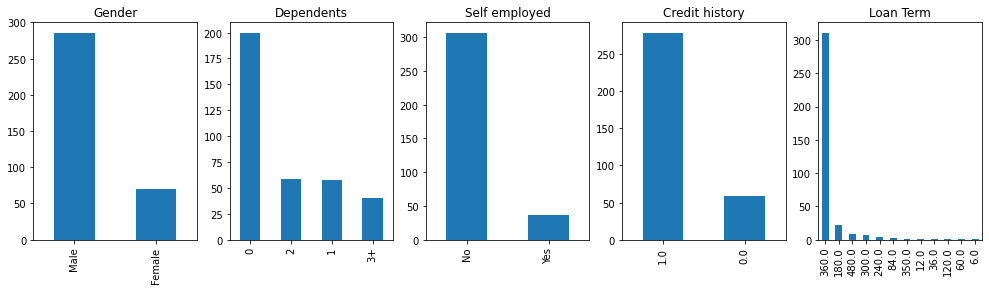

In [43]:
# Checking the distributions of categorical features with missing values

fig, ax  = plt.subplots(1,5, figsize=(17,4))

test_df["Gender"].value_counts().plot(kind="bar", ax=ax[0], title="Gender")
test_df["Dependents"].value_counts().plot(kind="bar", ax=ax[1], title="Dependents")
test_df["Self_Employed"].value_counts().plot(kind="bar", ax=ax[2], title="Self employed")
test_df["Credit_History"].value_counts().plot(kind="bar", ax=ax[3], title="Credit history")
test_df["Loan_Amount_Term"].value_counts().plot(kind="bar", ax=ax[4], title="Loan Term")

plt.show()

In [44]:
# Fill up the missing values

test_df["Gender"] = test_df["Gender"].fillna("Male")

test_df["Dependents"] = test_df["Dependents"].fillna("0")

test_df["Self_Employed"] = test_df["Self_Employed"].fillna("No")

testloan_mean = int(round(test_df["LoanAmount"].mean(),0))
test_df["LoanAmount"] = test_df["LoanAmount"].fillna(testloan_mean)

test_df["Loan_Amount_Term"] = test_df["Loan_Amount_Term"].fillna(360.0)

test_df["Credit_History"] = test_df["Credit_History"].fillna(1.0)

In [45]:
# Collecting separately categorical variable columns
labels = test_df[["Gender", "Married", "Dependents", "Education", "Self_Employed", "Loan_Amount_Term", "Credit_History", "Property_Area"]]

In [46]:
# Since we want to get a df with the same number of columns, encoding of "Property Area" has to be made by dummy encoding, as well 
area_dummie = pd.get_dummies(labels["Property_Area"], prefix="area")
labels = pd.concat([labels, area_dummie], axis=1)

# Dropping the original "Property Area" column
labels = labels.drop(columns={"Property_Area"})

# Convertin the codes to normal integers
labels["area_Rural"] = labels["area_Rural"].astype(int) 
labels["area_Semiurban"] = labels["area_Semiurban"].astype(int) 
labels["area_Urban"] = labels["area_Urban"].astype(int) 

In [47]:
# Encoding the rest of the catogorical variables the fastest way

col_list = labels.columns.tolist()

col_list = ["Gender","Married","Dependents","Education","Self_Employed","Loan_Amount_Term","Credit_History"]

for col in col_list:
    
    labels[col] = le.fit_transform(labels[col])

In [48]:
# Numerical variables

num_cols = test_df[["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]]

In [49]:
# Creating the final df for prediction 

pred_df = pd.concat([labels, num_cols], 1)

## Prediction

Choosing from the best perfomed models for the final predicition

In [50]:
# Logistic Regression

X_train = data.iloc[:,:-1]
y_train = data.iloc[:,-1]
    
scaler = StandardScaler()    
    
X_train = scaler.fit_transform(X_train)

X_test = pred_df.loc[:,:]

X_test = scaler.transform(X_test)

model = LogisticRegression()

model.fit(X_train, y_train)

final_logreg = model.predict(X_test)

In [51]:
# KNeighbors

model = KNeighborsClassifier(n_neighbors=10)

model.fit(X_train, y_train)

final_knn = model.predict(X_test)

In [52]:
# RandomForest

X_train = data.iloc[:,:-1]
y_train = data.iloc[:,-1]

X_test = pred_df.loc[:,:]

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)

model.fit(X_train, y_train)

final_rf = model.predict(X_test)

In [53]:
# GradientBoosting

X_train = data.iloc[:,:-1]
y_train = data.iloc[:,-1]

X_test = pred_df.loc[:,:]

model = GradientBoostingClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=1)

model.fit(X_train, y_train)

final_gb = model.predict(X_test)

In [54]:
# Taking the predicitions to the pred_df

pred_df["loan_status_logreg"] = final_logreg
pred_df["loan_status_knn"] = final_knn
pred_df["loan_status_rf"] = final_rf
pred_df["loan_status_gb"] = final_gb

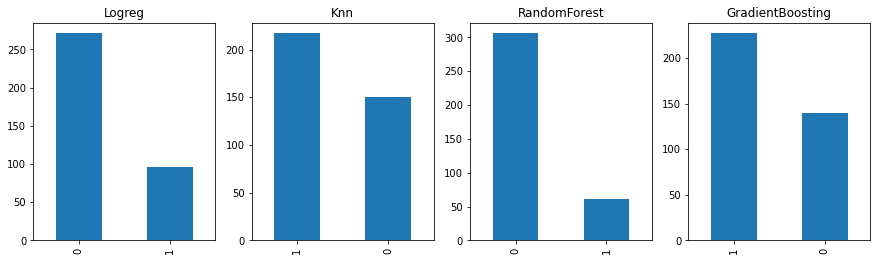

In [55]:
# Visualize the loan status predictions

fig, ax = plt.subplots(1,4, figsize=(15,4))

pred_df["loan_status_logreg"].value_counts().plot(kind="bar", title="Logreg", ax=ax[0])
pred_df["loan_status_knn"].value_counts().plot(kind="bar", title="Knn", ax=ax[1])
pred_df["loan_status_rf"].value_counts().plot(kind="bar", title="RandomForest", ax=ax[2])
pred_df["loan_status_gb"].value_counts().plot(kind="bar", title="GradientBoosting", ax=ax[3])

plt.show()